# Всяко бывает, да не со всеми  
**или**
## Краткое введение в некоторые проблемы исследований и статистики

Сегодня мы поговорим о том, почему одно измерение не показывает нам всё картины (и почему [Азимов](https://en.wikipedia.org/wiki/Franchise_(short_story)) был неправ, утверждая, что президента может выбирать один выборщик, а судить по последнему деянию, как в сериале ["Небесный суд"](https://www.kinopoisk.ru/series/640733/) нельзя), как можно просто понять, что два распределения различны, и то, что уже хватит проводить эксперименты. Как увеличить или уменьшить неравенство между точками, для которых проведены измерения.

В промежутках нам будут попадаться фрагменты кода, который генерирует графики и позволяет поиграть со статистическими распределениями. 

А потом мы окунёмся в мир книг, разорвём их на кусочки, будем исследовать душу автора и совершать ошибки.

## Почему нельзя сравнивать только средние значения, но нужен доверительный интервал и t-test
<a name="#t-test"></a>
Давайте посмотрим на то, как ведет себя случайная переменная. Для этого нам потребуются массивы чисел, статистика, рисунки и видео.

In [1]:
import pathlib
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Video

import conllu

%matplotlib inline



/home/edward/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Для начала посмотрим как распределение генерируется из отдельных точек.

Создадим генератор случайных числе с равномерным законом распределения и сгенерируем тысячу точек. Нарисуем каждую отдельную точку в том месте, где она была сгенерирована, но если точки начинают накладываться, сдвинем новую точку немного вверх или вниз, пока она не перестанет накладываться на другие. (Это называется swarm plot.) Посмотрим какое распределение получится.

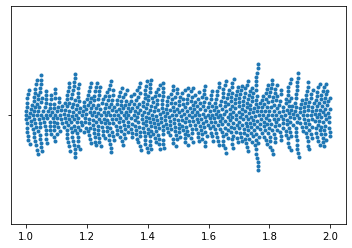

In [2]:
u1 = stats.uniform(loc=1, scale=1)
r = u1.rvs(size=1000)
ax = sns.swarmplot(x=r, size=4)

Теперь сделаем тоже самое для нормального распределения.

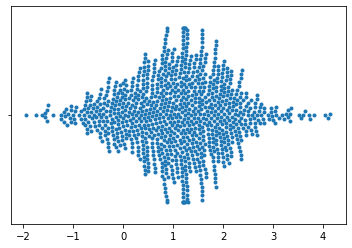

In [3]:
n1 = stats.norm(loc=1, scale=1)
r = n1.rvs(size=1000)
ax = sns.swarmplot(x=r, size=4)

Оно снова выглядит не так ровно, как должно было бы выглядеть идеальное распределение. Потому что никто не идеален.  
Но почему так происходит? Потому что по мере вычислений точки приходят случайным образом, а не так, чтобы скомпенсировать неидеальность нормального распределения.  
Чтобы сгладить картину, построим гистограмму распределения точек по разному количеству интервалов. Как видно из рисунка, чем больше дискретизация, тем больше отклонений. Потому что при малом количестве интервалов в них собираетсяя больше точек, которые улучшают статистику.

In [4]:
Video("videos/make_normal.mp4", width=800)

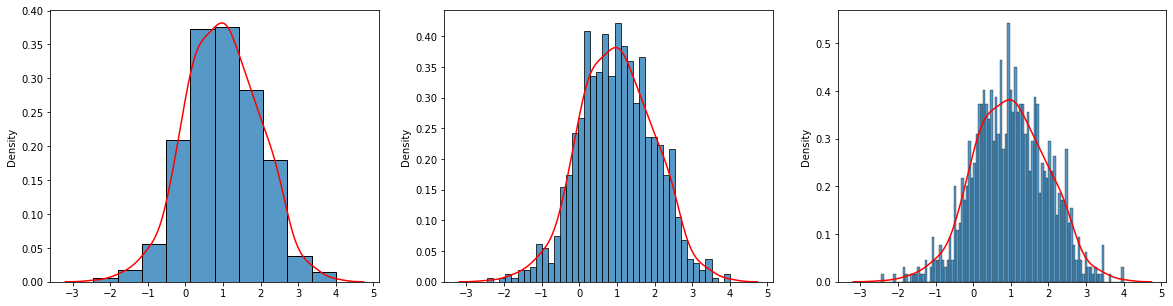

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
r1 = n1.rvs(size=1000)
ax = sns.histplot(r1, bins=10, ax=axes[0], stat="density"); #, kde=True); - the same but different.
sns.kdeplot(r1, ax=ax, color='red');
ax = sns.histplot(r1, bins=40, ax=axes[1], stat="density");
sns.kdeplot(r1, ax=ax, color='red');
ax = sns.histplot(r1, bins=100, ax=axes[2], stat="density");
sns.kdeplot(r1, ax=ax, color='red');


Попробуем взять несколько групп случайно сгенерированных точек и посмотреть невооруженным глазом насколько они отличаются друг от друга.

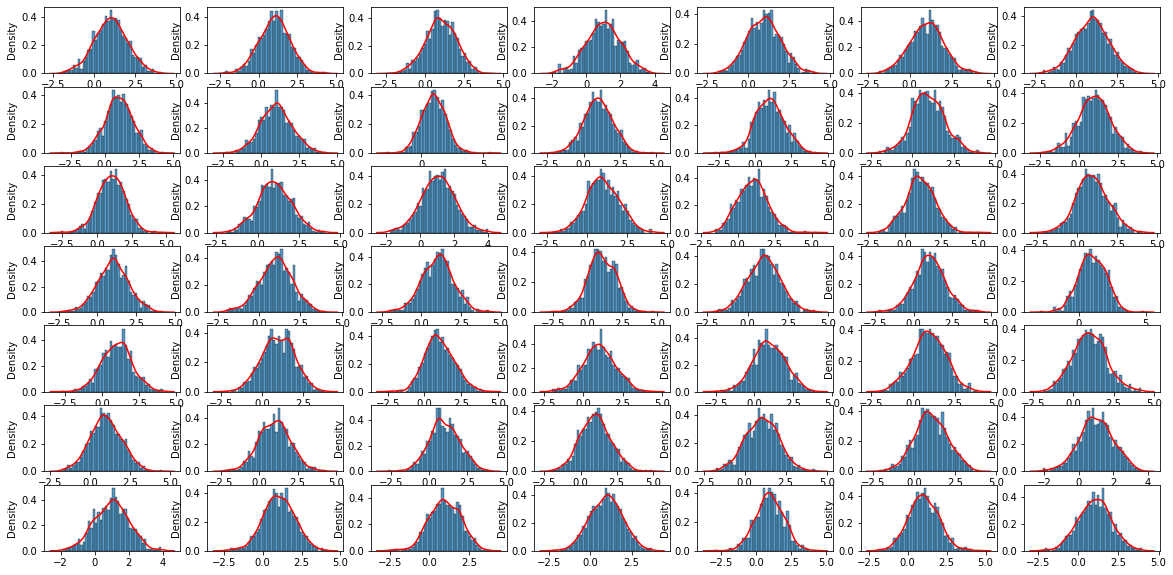

In [6]:
fig, axes = plt.subplots(7, 7, figsize=(20,10))
avgs = []
for i in range(7):
    for j in range(7):
        r1 = n1.rvs(size=1000)
        sns.histplot(r1, bins=40, ax=axes[i][j], stat="density")
        sns.kdeplot(r1, ax=axes[i][j], color='red')
        avgs.append(np.average(r1))

Тем же невооруженным глазом видно, что распределения отличаются друг от друга. Более того, несмотря на то, что они генерировались для одного и того же распределения, у которого среднее и дисперсия равны единице, средние значения отличаются от одной группы точек к другой.

Давайте сгенерируем достаточно много распределений, чтобы на них можно было делать какие-то твердые выводы, и посмотрим на распределение средних значений по группам точек. Как видно из рисунка (и это можно доказать формально) средние значения (и медианы) также распределены нормально. То есть разные выборки для одного и того же распределения различаются между собой, разичны и их средние значения, и тот факт, что для выборки среднее принимает какое-то значение ещё не означает, что среднее для всего распределения находится там же.

In [7]:
Video("videos/avg_normal.mp4", width=800)

<Axes: ylabel='Count'>

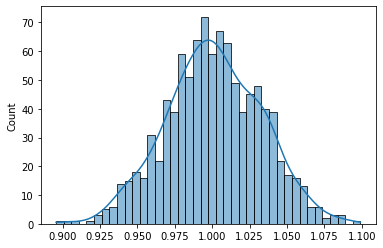

In [8]:
avgs = []
for i in range(1000):
    r1 = n1.rvs(size=1000)
    avgs.append(np.average(r1))
    
sns.histplot(avgs, bins=40, kde=True)


А теперь проведем следующий эксперимент. Возьмем один набор из тысячи точек и возьмем разные его подвыборки размером в сто точек. Посмотрим как разные подвыборки отличаются друг от друга и от итогового распределения.

['1.027', '0.97429', '0.96932', '1.1438', '0.8769', '0.83351', '0.94413', '0.87023', '1.0536']


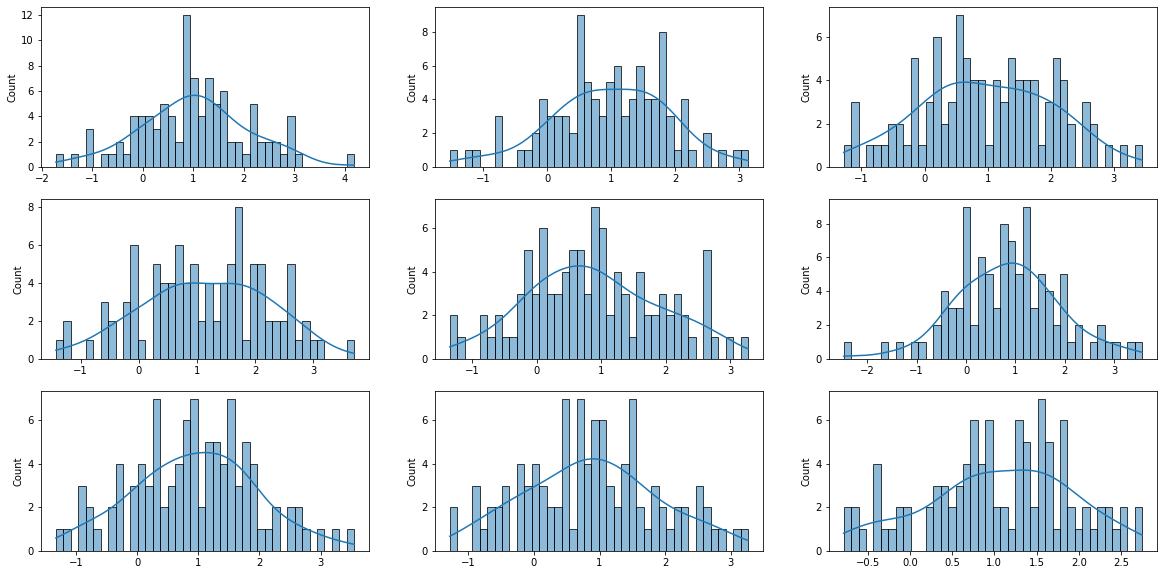

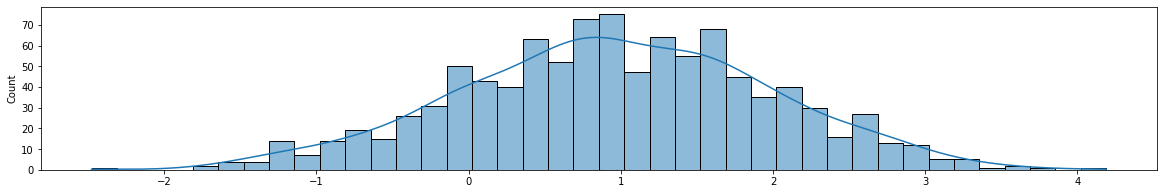

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
r1 = n1.rvs(size=1000)
avgs = []
for i in range(3):
    for j in range(3):
        sns.histplot(x=r1[(i*3+j)*100:(i*3+j+1)*100], bins=40, ax=axes[i][j], kde=True)
        avgs.append(np.average(r1[(i*3+j)*100:(i*3+j+1)*100]))
# fig.show()        

fig, ax = plt.subplots(1, 1, figsize=(20, 3))
sns.histplot(x=r1, bins=40, ax=ax, kde=True)
for a in avgs:
    sns.lineplot(x=[a, a], y=[0, 0.5], color="r", ax=ax)
    
print([f"{a:1.5}" for a in avgs])

А теперь возьмем нарастающим итогом, чтобы число точек увеличивалось и среднее приближалось к настоящему.

['1.027', '0.97429', '0.96932', '1.1438', '0.8769', '0.83351', '0.94413', '0.87023', '1.0536']


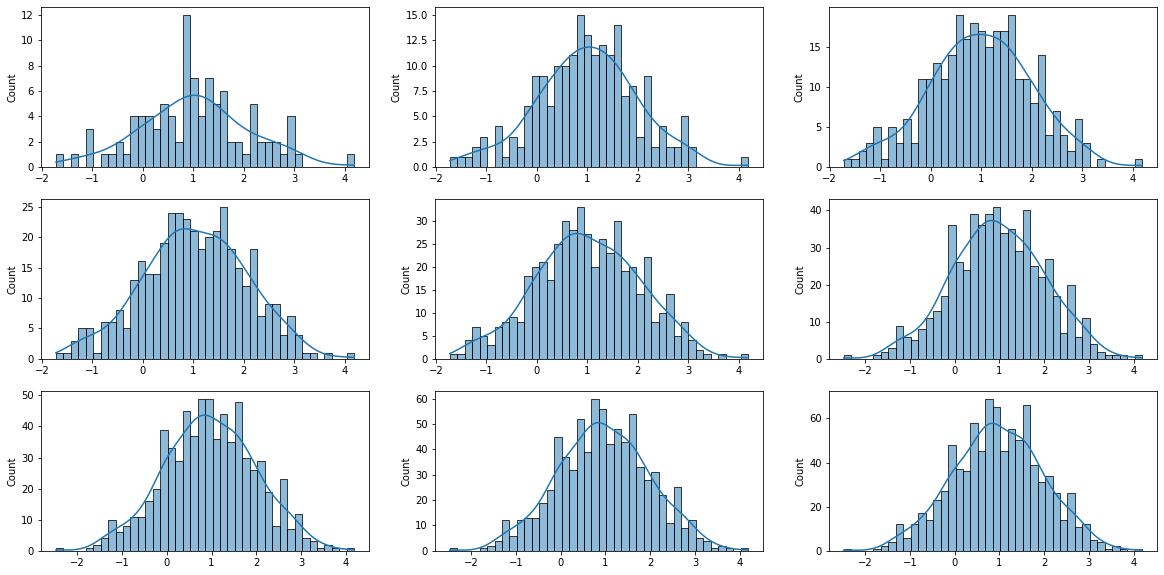

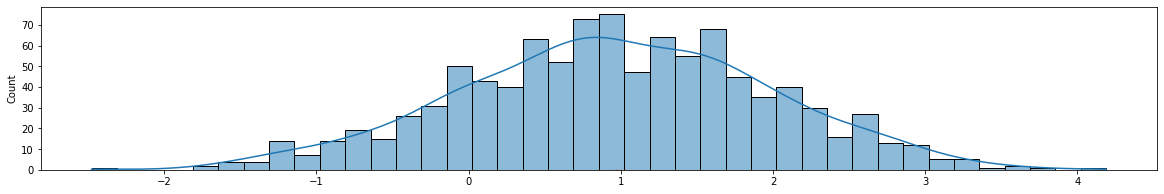

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
# Берем распределение из предыдущего графика.
# r1 = n1.rvs(size=1000)
avgs_2 = []
for i in range(3):
    for j in range(3):
        sns.histplot(x=r1[:(i*3+j+1)*100], bins=40, ax=axes[i][j], kde=True)
        avgs_2.append(np.average(r1[:(i*3+j+1)*100]))
# fig.show()        

fig, ax = plt.subplots(1, 1, figsize=(20, 3))
sns.histplot(x=r1, bins=40, ax=ax, kde=True)
for a in avgs_2:
    sns.lineplot(x=[a, a], y=[0, 0.5], color="r", ax=ax)
    
print([f"{a:1.5}" for a in avgs])

Получается, что на отдельной подвыборке мы можем отклониться от среднего для выборки, причем средние значения по подвыборкам распределены нормально. Чем больше мы берем точек в подвыборке, тем ближе мы попадаем к настоящему среднему мы попадаем. Два этих факта отражает доверительный интервал, который показывает отрезок, в который попадает истинное среднее с некоторой вероятностью.

$ se=\sqrt{\frac{\sum{x_i-\overline{x}}}{n-1}}$; $\mu=\overline{x}\pm Z_{\alpha/2}*\frac{se}{\sqrt{n}}$

Для 95% интервала $Z_{\alpha/2}=1.96$

Посмотрим какие у нас получились средние значения и доверительные интервалы для наших подвыборок.

In [11]:
Video("videos/calc_ci2.mp4", width=800)

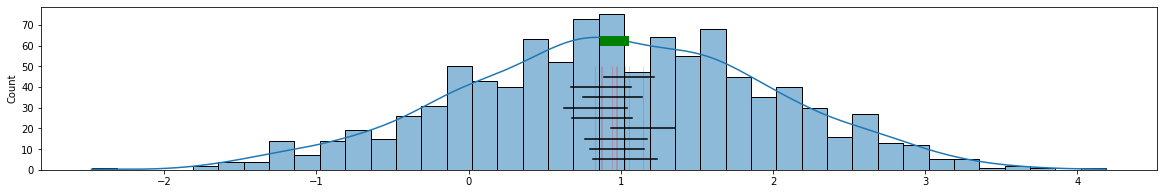

In [12]:
def get_conf_interval(r1):
    a = np.average(r1)
    se1 = a - 1.96 * np.std(r1) / np.sqrt(len(r1))
    se2 = a + 1.96 * np.std(r1) / np.sqrt(len(r1))
    return se1, se2

fig, ax = plt.subplots(1, 1, figsize=(20, 3))

sns.histplot(r1, bins=40, ax=ax, kde=True)
for a in avgs:
    sns.lineplot(x=[a, a], y=[0, 50], color="r", ax=ax)

sns.lineplot(x=get_conf_interval(r1), y=[62, 62], color="g", linewidth=10, ax=ax)

for i in range(len(avgs)):
    sns.lineplot(x=get_conf_interval(r1[i*100: (i+1)*100]), y=[5+i*5, 5+i*5], color="k", ax=ax)


А теперь посмотрим как будет меняться доверительный интервал, если мы будем постепенно добавлять к нему данные.

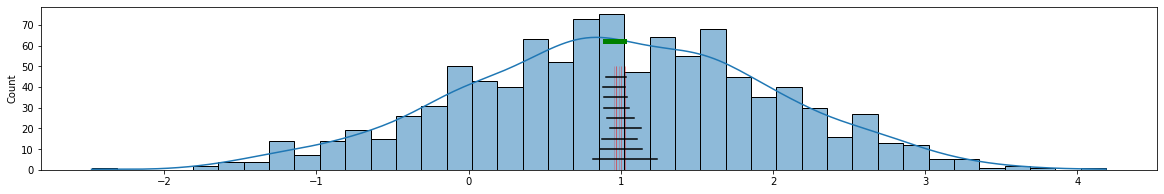

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20, 3))

sns.histplot(r1, bins=40, ax=ax, kde=True)
for a in avgs_2:
    sns.lineplot(x=[a, a], y=[0, 50], color="r", ax=ax)
sns.lineplot(x=get_conf_interval(r1), y=[62, 62], color="g", linewidth=5, ax=ax)

for i in range(len(avgs)):
    sns.lineplot(x=get_conf_interval(r1[: (i+1)*100]), y=[5+i*5, 5+i*5], color="k", ax=ax)


Теперь возьмем какое-то третье распределение, также нормальное, но со средним в 1.2, и помотрим как предыдущее будет соотноситься с ним. С некоторой точностью эти два распределения должны давать нам разные результаты. Но так как они оба распределены по нормальному закону, то их множества значений могут пересекаться. В какой момент мы сможем утверждать, что распределения различны? Когда можно сказать, что мы набрали достаточную статистику для такого утверждения?

Для иллюстрации посмотрим на подвыборки из 10 элементов для двух выбранных распределений (дисперсия равна 1, среднее 1 и 1.2, соответственно).

In [14]:
n2 = stats.norm(loc=1.2, scale=1)
r2 = n2.rvs(size=1000)

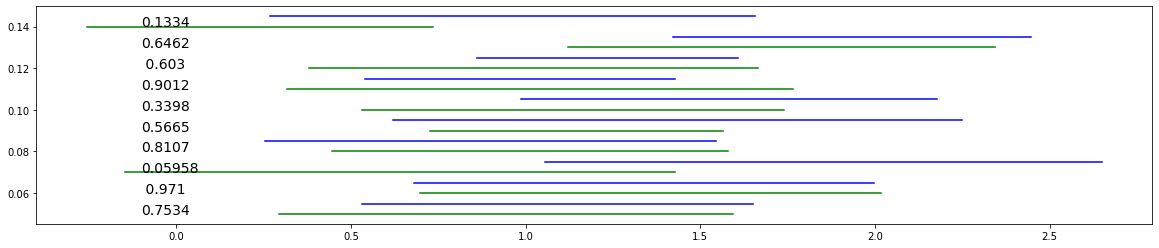

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))

for i in range(10):
    sns.lineplot(x=get_conf_interval(r1[i*10: (i+1)*10]), y=[0.05+i*0.01, 0.05+i*0.01], color="g", ax=ax)
    sns.lineplot(x=get_conf_interval(r2[i*10: (i+1)*10]), y=[0.055+i*0.01, 0.055+i*0.01], color="b", ax=ax)
    ax.text(x=-0.1, y=0.05+i*0.01, 
            s=f'{stats.ttest_ind(r1[i*10: (i+1)*10], r2[i*10: (i+1)*10]).pvalue:6.4}',
            fontdict={'fontsize':14})

Как видно из рисунка, доверительные интервалы для каждого подсножества точек существенно пересекаются. Это означает, что мы не можем постулировать, что распределения различны. С вероятностью около 5% среднее значение может находиться на пересечении.  
Кстати, для оценки вероятности, того, что среднее находится в этом пересечении, используется тест Стьюдента. Его p-value показывает эту самую вероятность. Значения p-value для нашего случая показаны на графике слева.

Теперь посмотрим теперь на выборки из 20 объектов.

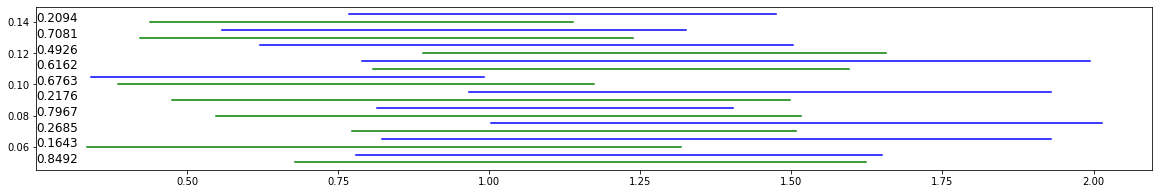

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20, 3))

for i in range(10):
    sns.lineplot(x=get_conf_interval(r1[i*20: (i+1)*20]), y=[0.05+i*0.01, 0.05+i*0.01], color="g", ax=ax)
    sns.lineplot(x=get_conf_interval(r2[i*20: (i+1)*20]), y=[0.055+i*0.01, 0.055+i*0.01], color="b", ax=ax)
    ax.text(x=0.25, y=0.05+i*0.01, 
            s=f'{stats.ttest_ind(r1[i*20: (i+1)*20], r2[i*20: (i+1)*20]).pvalue:6.4}',
            fontdict={'fontsize':12})

Всё ещё сложно что-то утверждать. Или разница слишком мала, или это одно и то же распределение. Увеличим число объектов до 100.

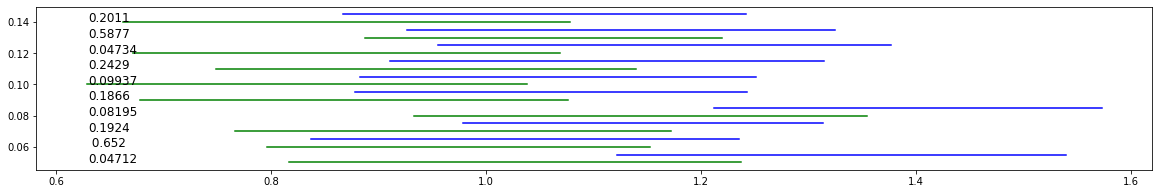

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 3))

for i in range(10):
    sns.lineplot(x=get_conf_interval(r1[i*100: (i+1)*100]), y=[0.05+i*0.01, 0.05+i*0.01], color="g", ax=ax)
    sns.lineplot(x=get_conf_interval(r2[i*100: (i+1)*100]), y=[0.055+i*0.01, 0.055+i*0.01], color="b", ax=ax)
    ax.text(x=0.63, y=0.05+i*0.01, 
            s=f'{stats.ttest_ind(r1[i*100: (i+1)*100], r2[i*100: (i+1)*100]).pvalue:6.4}',
            fontdict={'fontsize':12})

Здесь видно, что доверительные интервалы могут не пересекаться. Но могут и пересечься. Значит 20 объектов может не хватить для достоверного утверждения различий.

Попробуем брать объекты постепенно увеличивая их количество от 100 до 1000.

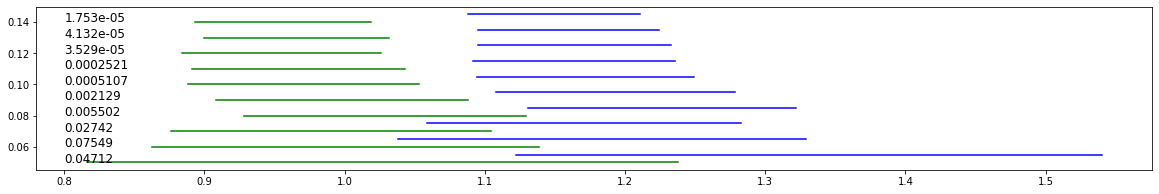

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20, 3))

for i in range(10):
    sns.lineplot(x=get_conf_interval(r1[: (i+1)*100]), y=[0.05+i*0.01, 0.05+i*0.01], color="g", ax=ax)
    sns.lineplot(x=get_conf_interval(r2[: (i+1)*100]), y=[0.055+i*0.01, 0.055+i*0.01], color="b", ax=ax)
    ax.text(x=0.8, y=0.05+i*0.01, 
            s=f'{stats.ttest_ind(r1[: (i+1)*100], r2[: (i+1)*100]).pvalue:6.4}',
            fontdict={'fontsize':12})

Видно, что достоверные отличия начинают быть видны от 700 объектов. Хотя, например, на 600 объектах пересечение настолько мало, что вероятность того, что средние для обоих распределений попадут в этот интервал, значительно ниже 5%.

Для того, чтобы оценить, сколько нам необходимо объектов для подтверждения факта, что распределения различны, используем [Power Analysis](https://en.wikipedia.org/wiki/Power_(statistics)) \([или вот](http://www.statskingdom.com/doc_test_power.html)\). По нему надо посчитать ![](https://wikimedia.org/api/rest_v1/media/math/render/svg/d7326aa9d5d7c4c8bcbb9c569949cd1e53203a88) Здесь **Ф** - это куммулятивное распределение нормальной функции, 1.64 - константа для 95% уверенности, после минуса - обратное стандартное отклонение (которое используется для расчета доверительного интервала), умноженное на дельту между средними значениями двух распределений. Это значение должно быть >95%, но если не вычитать из 1, то <5%.

In [19]:
def calcStatPower(data1, data2):
    delta = np.abs(np.average(data1) - np.average(data2))
    se = np.std(data1) / np.sqrt(len(data1))
    power = stats.norm.cdf(1.645 - delta / se)
    
    return power

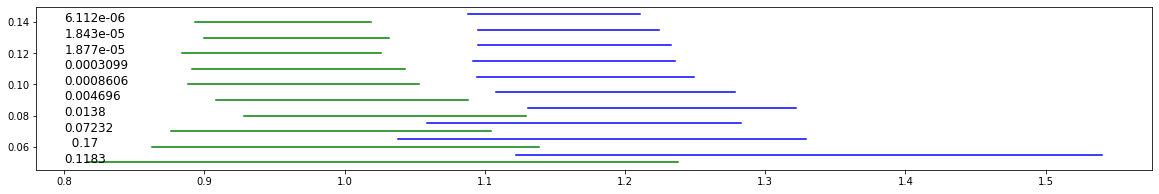

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(20, 3))

for i in range(10):
    sns.lineplot(x=get_conf_interval(r1[: (i+1)*100]), y=[0.05+i*0.01, 0.05+i*0.01], color="g", ax=ax)
    sns.lineplot(x=get_conf_interval(r2[: (i+1)*100]), y=[0.055+i*0.01, 0.055+i*0.01], color="b", ax=ax)

    ax.text(x=0.8, y=0.05+i*0.01, 
            s=f'{calcStatPower(r1[: (i+1)*100], r2[: (i+1)*100]):6.4}',
            fontdict={'fontsize':12})

Выше приведены значения статистической силы и доверительные интервалы. Как видно, статистическая сила высока, когда пересечение становится очень маленьким, либо интервалы полностью не пересекаются.

Кстати, для медианы наблюдается такая же закономерность, что и для среднего.

<Axes: ylabel='Count'>

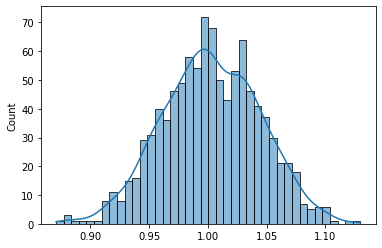

In [21]:
avgs = []
for i in range(1000):
    r1 = n1.rvs(size=1000)
    avgs.append(np.median(r1))
    
sns.histplot(avgs, bins=40, kde=True)


Кстати, об отличиях между средним и медианой. Возьмем гамма-распределение, показанное на рисунке ниже. 

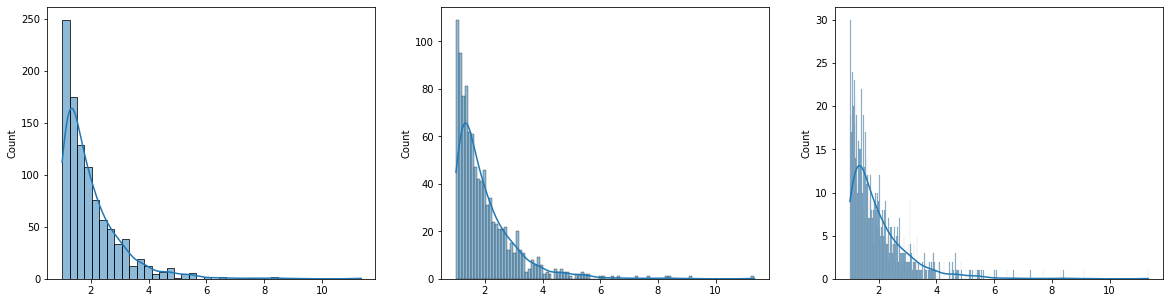

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
b1 = stats.gamma(1, 1)
br1 = b1.rvs(size=1000)
sns.histplot(br1, bins=40, kde=True, ax=axes[0]);
sns.histplot(br1, bins=100, kde=True, ax=axes[1]);
sns.histplot(br1, bins=500, kde=True, ax=axes[2]);

Легко увидеть, что оно несимметрично. Как следствие, его среднее и медиана сильно отличаются между собой. Подобное различие можно трактовать как показатель несимметричности распределения.

А медиана ведет себя так же как и среднее?

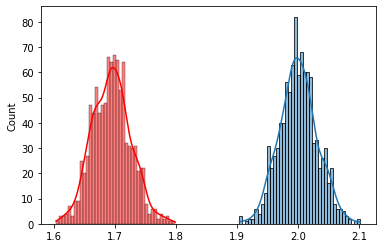

In [23]:
avgs = []
meds = []
for i in range(1000):
    r1 = b1.rvs(size=1000)
    avgs.append(np.average(r1))
    meds.append(np.median(r1))
    
ax = sns.histplot(avgs, bins=40, kde=True)
ax = sns.histplot(meds, bins=40, kde=True, color="r", ax=ax)


Теперь попытаемся оценить степень этой несимметричности при помощи диаграммы размаха. Ниже показаны диаграммы для гамма распределения (очень несимметричного), и распределений средних и демиан (ближе к нормальному распределению).

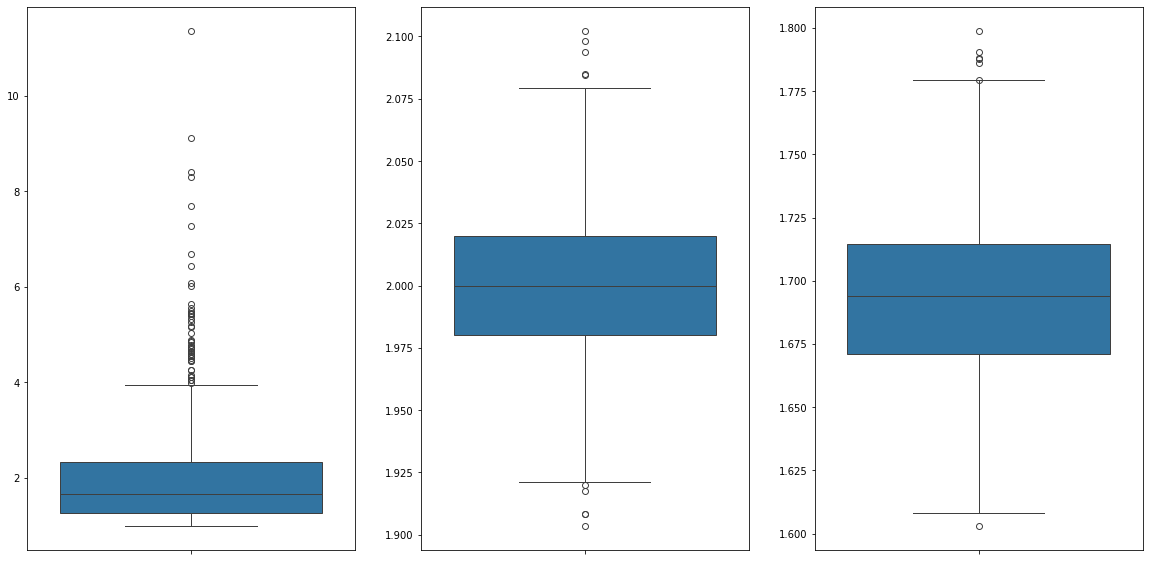

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
sns.boxplot(y=br1, ax=axes[0]);
sns.boxplot(y=avgs, ax=axes[1]);
sns.boxplot(y=meds, ax=axes[2]);

## Как преобразовать пространство
<a name="как-преобразовать-пространство"></a>
Теперь от одного математического трюка перейдем к другому. Иногда нам надо сделатьп реобразование пространства так, чтобы точки расположились иначе. Для этого мы можем от исходного пространства признаков перейти к преобразованному пространству. Например, на свете существуют степени (включая корни) и логарифмы. Видео ниже, с одной стороны, напоминает нам о том, как они выглядят, а с другой стороны, показывают, что мы можем уйти от обычного "линейного" расположения точек к новому, преобразованному. При этом единица в старом пространстве станет чем-то иным в новом пространстве.

Так, например, если мы используем квадрат расстояния, то мы стимулируем гораздо большую разницу для точек с большими значениями. На этом и основывается метод наименьших квадратов, который старается сделать так, чтобы линия походила примерно посредине всех точек.  
Если бы мерили расстояния линейно, то одна ошибка на 10 была бы полностью эквивалентна десяти ошибкам по 1. В случае с квадратами, если у нас появится точка, которая находится далеко от линии, её квадрат будет равен 100. То есть для её компенсации нам потребуется уже 100 точек с ошибкой 1. Может оказаться, что нам проще подойти ближе к этой одной далекой точке, чем стараться угодить 100 точкам с маленькой ошибкой.

Логарифм и корень делуют обратную операцию - они делают большую ошибку не такой значительной, какой она была в линейном пространстве. Ошибка в 100 после корня компенсируется лишь 10 отклонениями в другую сторону по 1.

In [25]:
Video('videos/func_log.mp4')

Теперь глазами оценим разницу в искажениях, которые происходят после разных нелинейных преобразований пространства.

In [26]:
Video('videos/shift_log.mp4')

Помимо этого, мы можем нормировать наши точки, чтобы они располагались на одной линии.

В результате всех этих преобразований меняются и расстояния между точками в этом новом пространстве. Посмотрим на разные формулы расчета расстояния (Евклид и косинус) после разных преобразований.

In [27]:
Video('videos/normalize_points.mp4')